In [78]:
import pandas as pd
import numpy as np
from scipy import integrate
import scipy.interpolate as spl
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("default")

In [10]:
isoc_file = '/Users/sara/Desktop/StarCluster/data/iso_age_8.104_mh_0.006.csv'
isoc = pd.read_csv(isoc_file)

In [13]:
# 初始质量函数
# generate the mass catalog follow the selected IMF 
def fun_IMF(m_x,label='Kroupa'):
    '''
    Initial Mass Funcation
    label = ['Salpeter','Kroupa','Chabrier']
    '''
    while label == 'Salpeter':
        if m_x < 0.1:
            return 0
        elif m_x < 100:
            return m_x**(-2.35)
        else : 
            return 0
    
    while label == 'Kroupa':
        if m_x < 0.08 : 
            return 0
        elif m_x < 0.5 : 
            return 2*m_x**(-1.3)
        elif m_x < 150:
            return m_x**(-2.3)
        else :
            return 0
        
        
    while label == 'Chabrier':
        if m_x < 0.07 : 
            return 0
        elif m_x < 1.0 : 
            return m_x**(-1.55)
        elif m_x < 100 : 
            return m_x**(-2.7)
        else : 
            return 0

# 返回IMF的pdf       
def pdf_IMF(m_x,m_min,m_max,label='Kroupa'):
    if m_x < m_min or m_x > m_max:
        return 0
    else : 
        return fun_IMF(m_x,label)/integrate.quad(lambda x : fun_IMF(x,label), m_min, m_max)[0]

# 按照 初始质量函数 随机生成 m_n 个范围在 (m_min,m_max) 之间的质量 
def random_IMF(m_n, m_min, m_max,label='Kroupa'):
    m_result = []
    c = pdf_IMF(m_min, m_min, m_max, label)
    for i in range(m_n):
        m_flag = 0 # 标志，判断生成的 mass 是否已经到达设定的质量上限 m_max
        while m_flag == 0:
            m_x = random.uniform(m_min, m_max) # 从(m_min, m_max)的均匀分布中随机抽取一个数
            m_y = random.uniform(0,1) 
            if m_y < pdf_IMF(m_x, m_min, m_max, label)/c: 
                m_result.append(m_x)
                m_flag = 1
    return m_result

In [137]:
labelIMF='Kroupa'
bands = ['F606Wmag','F814Wmag']
dist_mod = 15 # 距离模数, dist in unit "Mpc"
fbin=0.35 # 双星比

temiso = isoc
tem = temiso
tem = tem[(tem['label']>0)&(tem['label']<=7)] # MS ~ EAGB

logAge = tem.iloc[0]['logAge']
MH = tem.iloc[0]['MH']
#tem['F814Wmag_obs'] = tem['F814Wmag'] + dist_mod

massmin = min(tem['Mini'])
massmax = max(tem['Mini'])

# 质量
mass = random_IMF(100000,massmin,massmax,label=labelIMF) # 生成初始质量 primass 
cat = pd.DataFrame(np.zeros((100000,1)),columns=['primass']) # 创建星表
cat['primass'] = mass
cat['age'] = logAge
cat['mh'] = MH

# 双星系统
secindex = random.sample(list(cat.index),k=int(len(cat)*fbin)) # 按双星比 fbin 随机抽取为双星系统的样本
cat['secmass'] = np.zeros(len(cat))
bintem = temiso[temiso['label']==1] # MS 主序
secmass = random_IMF(int(len(cat)*fbin),bintem['Mini'].min(),bintem['Mini'].max(),label=labelIMF) # 生成双星中伴星的初始质量
cat['secmass'][secindex] = secmass # 双星系统中伴星的质量

In [138]:
# 流量
for band in bands:
    cat['%s_pri'%(band)] = np.zeros(len(cat))
    cat['%s_sec'%(band)] = np.zeros(len(cat))
    
    if tem.iloc[-1]['label'] <= 3: # MS,SGB,RGB, 如果等时线样本 tem 的阶段到RGB为止
        iso1 = tem
        fmass_band1 = spl.interp1d(iso1['Mini'],iso1['%s'%(band)]) # 拟合流量-质量关系函数
        for h in range(len(cat)):
            cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 给 cat 表中对应的 primass 赋流量值
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex: 
            cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h]) # 按照伴星的质量 secmass 赋伴星的流量值
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h])) # 对双星系统，真实流量由主星和伴星共同贡献
            
    if tem.iloc[-1]['label']>3: # CHEB, CHEB_b, CHEB_r, EAGB, 如果等时线样本 tem 存在演化到 RGB 后的阶段 
        iso1 = tem[tem['label']<=3] # MS,SGB,RGB
        fmass_band1 = spl.interp1d(iso1['Mini'],iso1['%s'%(band)],fill_value='extrapolate')
               
        iso2 = tem[tem['label']>=4] # CHEB-EAGB,core He-burning, not include TP-AGB
        fmass_band2 = spl.interp1d(iso2['Mini'],iso2['%s'%(band)])
        mass_cut = iso2['Mini'].min() # CHEB 开始时的质量
        
        for h in range(len(cat)):
            if cat['primass'][h] < mass_cut: # 若初始质量 primass < EAGB 开始时的质量(处于 MS-RGB 阶段)
                cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 按照 MS-RGB 阶段的流量-质量关系赋值
            else : # 处于 CHEB-EAGB 阶段
                cat['%s_pri'%(band)][h] = fmass_band2(cat['primass'][h]) 
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex:
            if cat['secmass'][h] < mass_cut:
                cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h])
            else : 
                cat['%s_sec'%(band)][h] = fmass_band2(cat['secmass'][h])
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h]))           

In [139]:
def ferr_mag(x,factor=0.01): # 模糊因子
    return x*factor
# 流量的误差
for band in bands:
    cat['%s'%(band)] = cat['%s_true'%(band)] + dist_mod # 1、改正距离模数
    # uncertainties 无信息(无UNCER_FIT.csv文件)，定义 ferr_mag 函数代替
    # ferr_mag = spl.interp1d(uncer['mag'],uncer['%s_err'%(band)],fill_value='extrapolate')
    cat['%s_obs'%(band)] = np.zeros(len(cat))

    for i in range(len(cat)):
        temmag = cat['%s'%(band)][i] # 改正距离模数后的流量
        temerr = ferr_mag(temmag) # 再现 color spread, 流量的“人造误差”
        cat['%s_obs'%(band)][i] = random.gauss(temmag,temerr) # 2、观测流量从 N(temmag,temerr) 随机抽样获得     
    cat['%s_err'%(band)] = cat['%s_obs'%(band)]-cat['%s'%(band)] # 流量的实际误差
    
# 保留 ｜流量误差｜< 0.5 的数据
for band in bands:
    cat = cat[(cat['%s_err'%(band)]<0.5)&(cat['%s_err'%(band)]>-0.5)].reset_index(drop=True)

In [146]:
# 不完备性, 没做
# apply completeness map to the ssp with uncertainties 
# xbins = np.arange(float(config['OBJECT']['XMIN']),float(config['OBJECT']['XMAX']),float(config['OBJECT']['XBINSIZE']))
# ybins = np.arange(float(config['OBJECT']['YMIN']),float(config['OBJECT']['YMAX']),float(config['OBJECT']['YBINSIZE']))
# grid_x,grid_y = np.meshgrid(xbins,ybins)
# grid_z = np.zeros((len(ybins),len(xbins))) 

cat['color_obs'] = cat['%s_obs'%(bands[0])] - cat['%s_obs'%(bands[1])] # F606Wmag_obs - F814Wmag_obs
cat['mag_obs'] =  cat['%s_obs'%(bands[1])] # F814Wmag_obs

In [147]:
temcat = cat.dropna()

/var/folders/v3/plfs35nd7xs9ph8dyb74gftw0000gn/T/ipykernel_55043/2495796713.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['F606Wmag_obs'][index]-cat['F814Wmag_obs'][index], cat['F814Wmag_obs'][index],s=0.5,c='k',alpha=0.3,label='N = %d'%len(cat))
/var/folders/v3/plfs35nd7xs9ph8dyb74gftw0000gn/T/ipykernel_55043/2495796713.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['F606Wmag_obs'][index]-cat['F814Wmag_obs'][index], cat['F814Wmag_obs'][index],s=0.5,c='k',alpha=0.3,label='N = %d'%len(cat))
/var/folders/v3/plfs35nd7xs9ph8dyb74gftw0000gn/T/ipykernel_55043/2495796713.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['F606Wmag_obs'][index]-cat['F814Wmag_obs'][index], cat['F814Wmag_obs'][index],s=0.5,c='k',alpha=0.3,label='N = 

Text(0, 0.5, 'F606W (mag)')

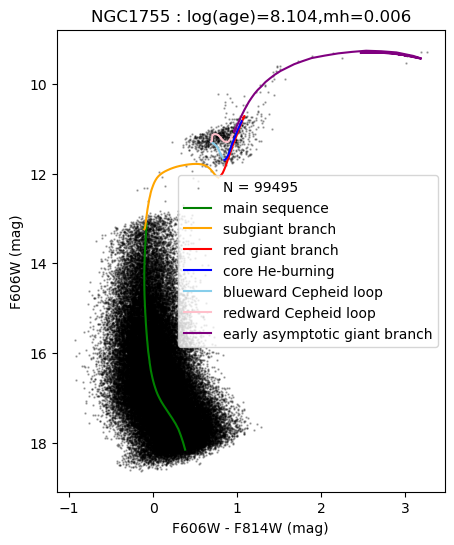

In [155]:
index = set(range(len(cat))) - set(np.where(cat['secmass']>0)[0])
MS = np.where((isoc['label']==1))[0] # main sequence
SGB = np.where((isoc['label']==2))[0] # subgiant branch, or Hertzsprung gap for more intermediate+massive stars
RGB = np.where((isoc['label']==3))[0] # red giant branch, or the quick stage of red giant for intermediate+massive stars
CHEB = np.where((isoc['label']==4))[0] # core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars
CHEB_b = np.where((isoc['label']==5))[0] # the blueward part of the Cepheid loop of intermediate+massive stars
CHEB_r = np.where((isoc['label']==6))[0] # the redward part of the Cepheid loop of intermediate+massive stars
EAGB = np.where((isoc['label']==7))[0] # the early asymptotic giant branch, or a quick stage of red giant for massive stars

name='NGC1755'
fig,ax =plt.subplots(figsize=(5,6))
ax.scatter(cat['F606Wmag_obs'][index]-cat['F814Wmag_obs'][index], cat['F814Wmag_obs'][index],s=0.5,c='k',alpha=0.3,label='N = %d'%len(cat))
ax.plot(isoc["F606Wmag"][MS]-isoc["F814Wmag"][MS], isoc["F814Wmag"][MS]+dist_mod, color='green', label='main sequence')
ax.plot(isoc["F606Wmag"][SGB]-isoc["F814Wmag"][SGB], isoc["F814Wmag"][SGB]+dist_mod, color='orange', label='subgiant branch')
ax.plot(isoc["F606Wmag"][RGB]-isoc["F814Wmag"][RGB], isoc["F814Wmag"][RGB]+dist_mod, color='red', label='red giant branch')
ax.plot(isoc["F606Wmag"][CHEB]-isoc["F814Wmag"][CHEB], isoc["F814Wmag"][CHEB]+dist_mod, color='blue', label='core He-burning')
ax.plot(isoc["F606Wmag"][CHEB_b]-isoc["F814Wmag"][CHEB_b], isoc["F814Wmag"][CHEB_b]+dist_mod, color='skyblue', label='blueward Cepheid loop')
ax.plot(isoc["F606Wmag"][CHEB_r]-isoc["F814Wmag"][CHEB_r], isoc["F814Wmag"][CHEB_r]+dist_mod, color='pink', label='redward Cepheid loop')
ax.plot(isoc["F606Wmag"][EAGB]-isoc["F814Wmag"][EAGB], isoc["F814Wmag"][EAGB]+dist_mod, color='purple', label='early asymptotic giant branch')
ax.invert_yaxis()
ax.legend()
ax.set_title('%s : log(age)=%s,mh=%s'%(name,str(logAge),str(MH)))
ax.set_xlabel("F606W - F814W (mag)")
ax.set_ylabel("F606W (mag)")